## Latent Dirichlet Allocation with Neural Networks

### Cleaning Dataset
To ensure consistency across the different models, our group will be using the same method of preprocessing and data cleaning methodology.  
Data cleaning was done with the following:
- Expanded contractions
- Removed Hashtags
- Removed airline mentions and kept their names
- Removed links
- Converted Emojis to texts

In [1]:
import re
import pandas as pd
import emoji
import nltk
import contractions  # Import contractions package for contraction expansion
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

file_path = "Tweets.csv"
df = pd.read_csv(file_path)

# Define the list of airlines (case-insensitive)
airline_list = ["VirginAmerica", "united", "SouthwestAir", "JetBlue", "USAirways", "AmericanAir"]

def clean_text(text):
    
    # Expand contractions using the contractions package
    text = contractions.fix(text)  # Converts contractions like "don't" to "do not", etc.
    
    # Remove hashtags while keeping the words
    text = re.sub(r'#(\w+)', r'\1', text)  # This removes the "#" symbol but keeps the word following it

    # Regex pattern for airline mentions (case-insensitive)
    airline_pattern = r'@(' + '|'.join(airline_list) + r')\b'
    match = re.search(airline_pattern, text, re.IGNORECASE)

    # Extract airline name if found
    airline = match.group(1) if match else "Unknown"

    # Remove only the airline mention
    text = re.sub(airline_pattern, '', text, flags=re.IGNORECASE).strip()

    # Check if text contains a link
    link_pattern = r'http\S+'  # Matches any URL starting with "http" or "https"
    has_link = 1 if re.search(link_pattern, text) else 0  # 1 if link exists, else 0

    # Remove the link from the text
    text_without_link = re.sub(link_pattern, '', text).strip()

    return airline, has_link, text_without_link

# Apply function and create new columns
df[['airline', 'has_link', 'clean_text']] = df['text'].apply(lambda x: pd.Series(clean_text(x)))

# Display first few rows
df[345:399]

# Convert Emojis to Text
def convert_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))  # Convert 😊 → " :blush: "

# Apply emoji conversion
df['clean_text_emoji'] = df['clean_text'].apply(convert_emojis)

# Display first few rows of the emoji-converted text
df[380:391]

,airline_sentiment,sentiment_confidence,text,airline,has_link,clean_text,clean_text_emoji
380,positive,1.0000,@VirginAmerica gave a credit for my Late Fligh...,VirginAmerica,0,gave a credit for my Late Flight flight yester...,gave a credit for my Late Flight flight yester...
381,neutral,1.0000,@VirginAmerica I need a receipt for a flight c...,VirginAmerica,0,I need a receipt for a flight change. Can you ...,I need a receipt for a flight change. Can you ...
382,negative,1.0000,"@VirginAmerica, I submitted a status match req...",VirginAmerica,0,", I submitted a status match request a while b...",", I submitted a status match request a while b..."
383,positive,1.0000,@VirginAmerica had me at their safety video . ...,VirginAmerica,1,had me at their safety video . . . LOVED my ...,had me at their safety video . . . LOVED my ...
384,positive,0.6871,@VirginAmerica that doesn't look to fat to me!...,VirginAmerica,0,that does not look to fat to me! It looks yummy!,that does not look to fat to me! It looks yummy!
385,neutral,1.0000,@VirginAmerica CEO says #Southwest &amp; #jetb...,VirginAmerica,1,CEO says Southwest &amp; jetblue have strayed ...,CEO says Southwest &amp; jetblue have strayed ...
386,neutral,0.6811,@VirginAmerica a brilliant brisk am in Boston ...,VirginAmerica,1,a brilliant brisk am in Boston in cue for vx363,a brilliant brisk am in Boston in cue for vx363
387,neutral,1.0000,@VirginAmerica Atlantic ploughs a lone furrow ...,VirginAmerica,1,Atlantic ploughs a lone furrow in the MiddleEa...,Atlantic ploughs a lone furrow in the MiddleEa...
388,neutral,1.0000,@VirginAmerica Atlantic ploughs a lone furrow ...,VirginAmerica,1,Atlantic ploughs a lone furrow in the MiddleEa...,Atlantic ploughs a lone furrow in the MiddleEa...
389,neutral,0.7026,@VirginAmerica Atlantic ploughs a lone furrow ...,VirginAmerica,1,Atlantic ploughs a lone furrow in the MiddleEa...,Atlantic ploughs a lone furrow in the MiddleEa...


### Feature Extraction: Latent Dirichlet Allocation
For this approach, we will be using LDA for feature selection. LDA is a topic modeling technique that assumes that each tweet is a mixture of topics, where each topic is characterized over words.  
To determine the optimal number of topics, the coherence score was computed, which measures the consistency and quality of the topics.  
As seen from the plot, the optimal number of topics is 9.  
This approach was inspired from Blei et al. (2003) whereby they looked at how LDA worked and its various assumptions. They highlighted that the bag-of-words assumption allows words generated by the same topic to be allocated to several different topcis. In essence, bag-of-words ignores word order, suggesting that it is poor at deriving contexts
Despite the already short texts which implies minimal impact from lack of word order, we used deep learning methods such as LSTM and CNN to tackle this.

In [6]:
import pandas as pd
import numpy as np
import re
import gensim
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer


def tokenize_text(text):
    return text.split()  # Simple word split as a fallback

# Apply preprocessing
processed_texts = [tokenize_text(doc) for doc in df['clean_text_emoji']]

#  Create Dictionary & Corpus for LDA
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

#  Find Optimal Number of Topics
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10, step=1):
    """Finds the optimal number of topics using Coherence Score"""
    coherence_scores = []
    topic_range = range(start, limit + 1, step)

    for num_topics in topic_range:
        # Train LDA model
        lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=100)

        # Compute coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)

        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

    return topic_range, coherence_scores

# Compute coherence scores
topic_range, coherence_scores = compute_coherence_values(dictionary, corpus, processed_texts, start=2, limit=10, step=1)
print(processed_texts[:5])  # Check first 5 tokenized documents


Number of Topics: 2, Coherence Score: 0.3418
Number of Topics: 3, Coherence Score: 0.3299
Number of Topics: 4, Coherence Score: 0.3965
Number of Topics: 5, Coherence Score: 0.4069
Number of Topics: 6, Coherence Score: 0.4573
Number of Topics: 7, Coherence Score: 0.4580
Number of Topics: 8, Coherence Score: 0.5055
Number of Topics: 9, Coherence Score: 0.5098
Number of Topics: 10, Coherence Score: 0.4878
[['What', '@dhepburn', 'said.'], ['plus', 'you', 'have', 'added', 'commercials', 'to', 'the', 'experience...', 'tacky.'], ['I', 'did', 'not', 'today...', 'Must', 'mean', 'I', 'need', 'to', 'take', 'another', 'trip!'], ['it', 'is', 'really', 'aggressive', 'to', 'blast', 'obnoxious', '"entertainment"', 'in', 'your', "guests'", 'faces', '&amp;', 'they', 'have', 'little', 'recourse'], ['and', 'it', 'is', 'a', 'really', 'big', 'bad', 'thing', 'about', 'it']]


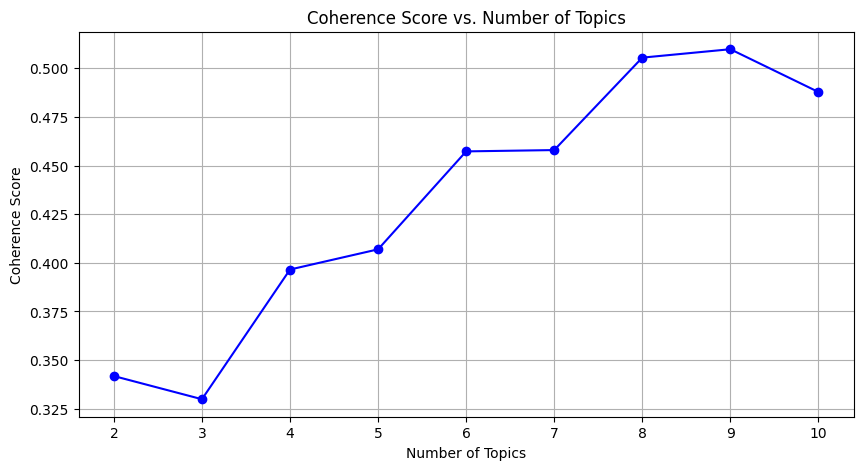

In [7]:
# Plot coherence scores
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

### LDA with LSTM
From here, we begin with our first methodology, which is to use Long Short-Term Memory for model training.  
LSTM is a type of recurrent neural network(RNN) designed to handle sequential data and overcome the vanishing problem that standard RNNs face. It is widely used for natural language processing.  
The train-test split is 80-20 in this instance and random state = 100  
Since our dataset is relatively small, we used batch size of 4 and 10 epochs for the model. Moreover, to improve performance, we used Swish activation function instead of the standard ReLU. 

In [8]:
import pandas as pd
import numpy as np
import re
import gensim
import tensorflow as tf
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# **1. Preprocess Text Data Without NLTK**
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation and special characters
    tokens = text.split()  # Tokenization (split by spaces)
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS and len(word) > 2]  # Remove stopwords & short words
    return tokens

df['processed_text'] = df['clean_text_emoji'].apply(preprocess_text)

# **2. Apply LDA for Topic Extraction**
dictionary = corpora.Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

lda_model = LdaModel(corpus=corpus, num_topics=9, id2word=dictionary, passes=15, random_state=100)

# Convert LDA topics to features
def get_lda_features(text):
    bow_vector = dictionary.doc2bow(text)
    topic_distribution = lda_model[bow_vector]  # Get topic distribution
    topic_vector = np.zeros(9)  # We defined 9 topics
    for topic, prob in topic_distribution:
        topic_vector[topic] = prob
    return topic_vector

df['lda_features'] = df['processed_text'].apply(get_lda_features)

# **3. Prepare Data for LSTM**
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text_emoji'])

X_text = tokenizer.texts_to_sequences(df['clean_text_emoji'])  # Convert text to sequences
X_text = pad_sequences(X_text, maxlen=20, padding='post')  # Pad sequences
X_lda = np.vstack(df['lda_features'].values)  # Convert LDA features to array
X = np.hstack((X_text, X_lda))  # Combine text and LDA features

# Encode Sentiment Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])
y = to_categorical(y, num_classes=3)  # Convert labels to one-hot encoding

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# **4. Build LSTM Model**
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_text.shape[1] + 3),
    LSTM(256, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation=tf.keras.activations.swish),
    Dense(3, activation='softmax')  # 3 sentiment classes: positive, negative, neutral
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM Model
model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test), verbose=1)

# Evaluate Model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Ensure correct label mapping
labels = list(label_encoder.classes_)  # ['negative', 'neutral', 'positive']

print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print(classification_report(y_test_classes, y_pred_classes, target_names=labels, labels=[0, 1, 2]))


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2928/2928 ━━━━━━━━━━━━━━━━━━━━ 97s 33ms/step - accuracy: 0.6556 - loss: 0.8178 - val_accuracy: 0.7524 - val_loss: 0.6276
Epoch 2/10
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 93s 32ms/step - accuracy: 0.7901 - loss: 0.5344 - val_accuracy: 0.7780 - val_loss: 0.5829
Epoch 3/10
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 92s 32ms/step - accuracy: 0.8600 - loss: 0.3939 - val_accuracy: 0.7787 - val_loss: 0.5752
Epoch 4/10
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 88s 30ms/step - accuracy: 0.9044 - loss: 0.2793 - val_accuracy: 0.7906 - val_loss: 0.5699
Epoch 5/10
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 103s 35ms/step - accuracy: 0.9356 - loss: 0.2024 - val_accuracy: 0.7732 - val_loss: 0.7047
Epoch 6/10
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 91s 31ms/step - accuracy: 0.9516 - loss: 0.1500 - val_accuracy: 0.7647 - val_loss: 0.8508
Epoch 7/10
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 92s 31ms/step - accuracy: 0.9609 - loss: 0.1184 - val_accuracy: 0.7637 - val_loss: 0.8983
Epoch 8/10
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - accuracy: 0.9699 - loss: 0.0

### Analysis: 
Evidently, we see that the model performed well at 75% accuracy and f1 score. However, we noted that the validation loss is extremely high >1. This suggests that the model is likely to be overfitting and memorising too much of the training data.  
As such, to reduce overfitting, we pivoted into the use of Convolutional Neural Networks.

### LDA with CNN  
Convolutional Neural Network is a type of deep learning model primarily used for image processing. However, there are instances whereby it is used for text and sequence-based tasks like NLP.  
This was inspired by Xu et al.(2015) whereby they investigated on using CNN for short text clustering.  
The idea here is to use LDA features previously retrieved as topic features inputs into CNN. CNN will then detect patterns in topic distributions and reduce dimensionality with pooling layers.  
Through a series of trial and error in terms of tuning the hyperparameter, such as increasing the number of layers, epochs, batchsize and dropout, the below code gives the best result.  
Not to mention, early-stopping was introduced to prevent the model from overfitting as well. In other words, when the validation loss fails to improve for 3 epochs, the model will stop training and retrieve the best result.  
This helps to keep the model in check and prevent the model from overfitting, which can happen quite easily in such ML techniques.  

In [9]:
import pandas as pd
import numpy as np
import re
import gensim
import tensorflow as tf
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping

# **3. Prepare Data for CNN**
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text_emoji'])

X_text = tokenizer.texts_to_sequences(df['clean_text_emoji'])  # Convert text to sequences
X_text = pad_sequences(X_text, maxlen=20, padding='post')  # Pad sequences
X_lda = np.vstack(df['lda_features'].values)  # Convert LDA features to array
X = np.hstack((X_text, X_lda))  # Combine text and LDA features

# Encode Sentiment Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])
y = to_categorical(y, num_classes=3)  # Convert labels to one-hot encoding

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# **4. Build CNN Model with Swish Activation (2 Blocks)**
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_text.shape[1] + 3),

    # First CNN Block
    Conv1D(filters=256, kernel_size=5, activation=tf.keras.activations.swish, padding='same'),
    BatchNormalization(),
    Dropout(0.5),

    # Second CNN Block
    Conv1D(filters=128, kernel_size=6, activation=tf.keras.activations.swish, padding='same'),
    BatchNormalization(),
    GlobalMaxPooling1D(),  

    # Fully Connected Layers
    Dense(256, activation=tf.keras.activations.swish),
    Dropout(0.4),
    Dense(64, activation=tf.keras.activations.swish),
    Dropout(0.3),
    Dense(32, activation=tf.keras.activations.swish),
    Dropout(0.3),

    # Output Layer
    Dense(3, activation='softmax')  # 3 sentiment classes: positive, negative, neutral
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,          # Stop after 3 epochs without improvement
                               restore_best_weights=True) 

# **5. Train CNN Model**
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1, callbacks = [early_stopping])

# **6. Evaluate Model**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Ensure correct label mapping
labels = list(label_encoder.classes_)  # ['negative', 'neutral', 'positive']

print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
precision = precision_score(y_test_classes, y_pred_classes, average=None)  # Precision per class
recall = recall_score(y_test_classes, y_pred_classes, average=None)  # Recall per class

for i, label in enumerate(labels):
    print(f"{label.capitalize()} Precision: {precision[i]:.4f}")
    print(f"{label.capitalize()} Recall: {recall[i]:.4f}")
print(classification_report(y_test_classes, y_pred_classes, target_names=labels, labels=[0, 1, 2]))

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


732/732 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.6142 - loss: 0.9420 - val_accuracy: 0.7339 - val_loss: 0.6965
Epoch 2/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7715 - loss: 0.5925 - val_accuracy: 0.7746 - val_loss: 0.5874
Epoch 3/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8409 - loss: 0.4635 - val_accuracy: 0.7862 - val_loss: 0.5591
Epoch 4/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8776 - loss: 0.3492 - val_accuracy: 0.7879 - val_loss: 0.5867
Epoch 5/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9086 - loss: 0.2710 - val_accuracy: 0.7770 - val_loss: 0.6221
Epoch 6/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.9336 - loss: 0.2178 - val_accuracy: 0.7811 - val_loss: 0.6850
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.7862021857923497
Negative Precision: 0.8373
Negative Recall: 0.8953
Neutral Precision: 0.6188
Neutral Recall: 0.5731
Positive Precision: 0.7661
Positive Recall: 0.6250
            

### Analysis:
Evidently, the model performance improved to 79% with a lower validation loss of 0.5591. 

### Further Improvements
Additionally, in order to further improve the model and combat misclassification in terms of neutral classes, as seen from its individual f1 score to be 0.6, we implemented margin-based approach.  
This serves to fine tune the margins between positive and negative such that if both are within 0.1 of each other, we will classify them as neutral.  
However, this did not improve model performance as the performance was marginally negatively affected.

In [10]:
# Custom margin-based decision function
def margin_based_classification(probabilities, margin=0.2):
    """
    Apply margin-based classification for sentiment analysis.
    
    Args:
        probabilities: Softmax output [Negative, Neutral, Positive]
        margin: Threshold for deciding when to classify as Neutral

    Returns:
        sentiment label index (0: Negative, 1: Neutral, 2: Positive)
    """
    neg, neu, pos = probabilities

    # If Positive and Negative are close (within margin), classify as Neutral
    if abs(pos - neg) < margin:
        return 1  # Neutral
    # If one sentiment is dominant, return it
    if pos > 0.5:
        return 2  # Positive
    if neg > 0.5:
        return 0  # Negative
    # If Neutral is dominant, keep it
    if neu > 0.5:
        return 1  # Neutral

    # Otherwise, assign to the highest probability class
    return np.argmax(probabilities)

# Apply the margin-based classification
y_pred_classes = np.array([margin_based_classification(probs) for probs in y_pred])
y_test_classes = np.argmax(y_test, axis=1)

# Print evaluation metrics
labels = list(label_encoder.classes_)  # ['negative', 'neutral', 'positive']
print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print(classification_report(y_test_classes, y_pred_classes, target_names=labels, labels=[0, 1, 2]))

Accuracy: 0.7838114754098361
              precision    recall  f1-score   support

    negative       0.84      0.89      0.87      1863
     neutral       0.59      0.59      0.59       609
    positive       0.80      0.60      0.69       456

    accuracy                           0.78      2928
   macro avg       0.74      0.69      0.71      2928
weighted avg       0.78      0.78      0.78      2928



### References
1. Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. Journal of Machine Learning Research 3 , 3. https://doi.org/https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf 
2. Xu, J., Wang, P., Tian, G., Xu, B., Zhao, J., Wang, F., & Hao, H. (2015). Short text clustering via Convolutional Neural Networks. Proceedings of the 1st Workshop on Vector Space Modeling for Natural Language Processing. https://doi.org/10.3115/v1/w15-1509 
